# Libraries

In [294]:
import numpy as np
import math
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from scipy.linalg import inv

# 1

In [345]:
def logistic(cov, beta):
    linear_combination = np.dot(cov, beta[1:]) + beta[0] 
    p = 1 / (1 + np.exp(-linear_combination)) 
    return p

def generate_logistic(beta, n_samples): 
    X = np.random.uniform(-2, 2, (n_samples, len(beta)-1))  
    logistic_probs = [logistic(row, beta) for row in X]  
    Y = np.random.binomial(1, logistic_probs)  
    return X, Y
beta=[0.1,1.1,-0.9]
X,Y=generate_logistic(beta,200)
print(np.bincount(Y))

[101  99]


# 2

## primary functions

In [326]:
def log_likelihood(X, y, beta):
    probs = np.array([logistic(X[i], beta) for i in range(len(X))])
    loglikelihood = np.sum(y * np.log(probs) + (1 - y) * np.log(1 - probs))
    return loglikelihood

def log_prior(beta, sd=1.5):
    logprior = -0.5 * np.sum(beta**2) / sd**2  
    logprior -= len(beta) * np.log(sd * np.sqrt(2 * np.pi))  
    return logprior

def log_posterior(X, y, beta, sd):
    loglikelihood = log_likelihood(X, y, beta)
    logprior = log_prior(beta, sd)
    return loglikelihood + logprior

def metropolis_hastings(X, y, num_samples=10000, proposalsd=1, priorsd=1.5):
    dim = X.shape[1]
    currentbeta = np.random.multivariate_normal(np.zeros(dim+1), priorsd**2 * np.identity(dim+1))
    samples = []
    acceptance = 0
    for _ in range(num_samples):
        beta_proposed = np.random.multivariate_normal(currentbeta, proposalsd**2 * np.identity(dim+1))
        currentlog = log_posterior(X, y, currentbeta, priorsd)
        proposedlog = log_posterior(X, y, beta_proposed, priorsd)
        alpha = min(1, np.exp(proposedlog - currentlog))

        if np.random.rand() < alpha:
            currentbeta = beta_proposed
            acceptance += 1     
        samples.append(currentbeta)

    samples=np.array(samples)
    
    return samples, acceptance / num_samples


## tuning function

In [327]:
def find_best_proposalsd(X, y, target_acceptance_rate, num_samples=50, priorsd=1.5):
    best_proposalsd = 0
    closest_acceptance_rate = float('inf')  # initialize with a large number
    best_acceptance_rate = 0
    
    for proposalsd in np.arange(0, 1.01, 0.01):
        _, acceptance_rate = metropolis_hastings(X, y, num_samples=num_samples, proposalsd=proposalsd, priorsd=priorsd)  
        acceptance_diff = abs(acceptance_rate - target_acceptance_rate)
        if acceptance_diff < closest_acceptance_rate:
            closest_acceptance_rate = acceptance_diff
            best_proposalsd = proposalsd
            best_acceptance_rate = acceptance_rate

    return best_proposalsd, best_acceptance_rate

In [328]:
bestsd,_=find_best_proposalsd(X,Y,target_acceptance_rate=0.234)
print(bestsd)

0.32


In [330]:
samples,acceptance_rate=metropolis_hastings(X, Y, num_samples=10000, proposalsd=bestsd, priorsd=1.5)

## Trace plots

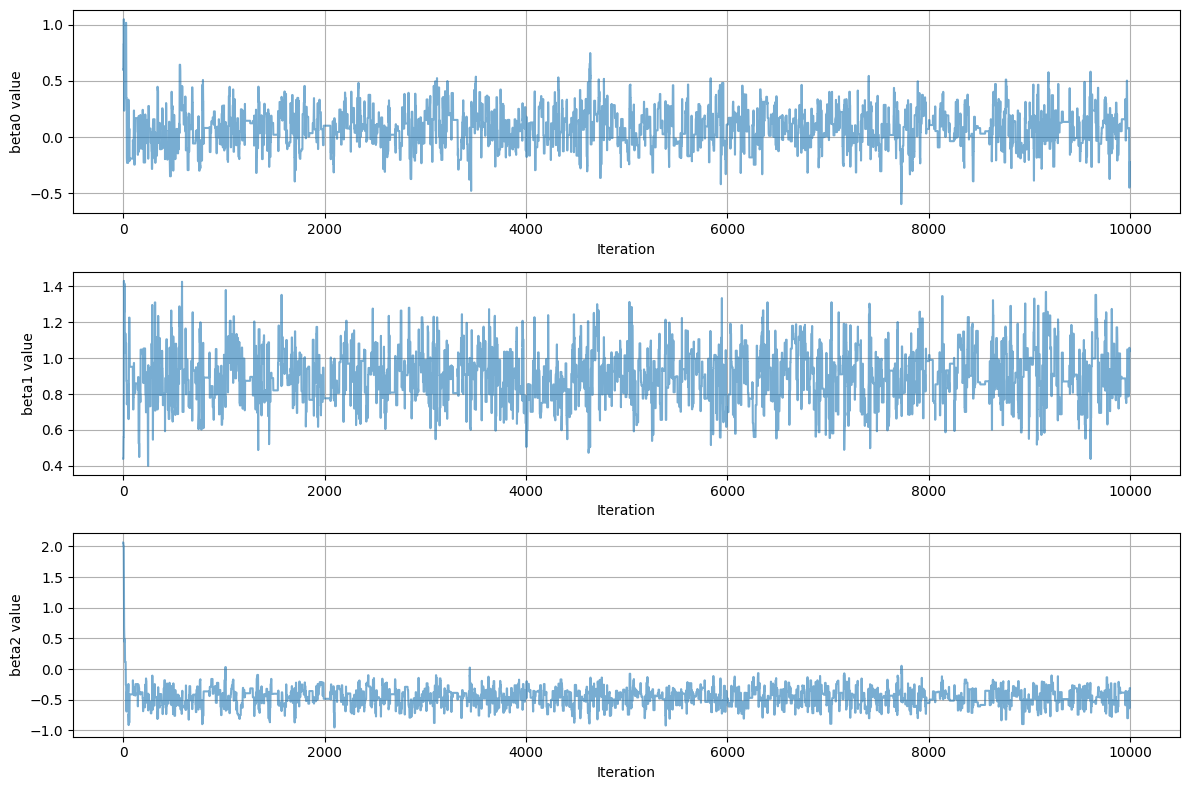

In [ ]:
parameter_names = ['beta0', 'beta1', 'beta2']
plt.figure(figsize=(12, 8))

for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(samples[:, i], alpha=0.6)
    plt.xlabel("Iteration")
    plt.ylabel(f"{parameter_names[i]} value")
    plt.grid(True)

plt.tight_layout()
plt.show()

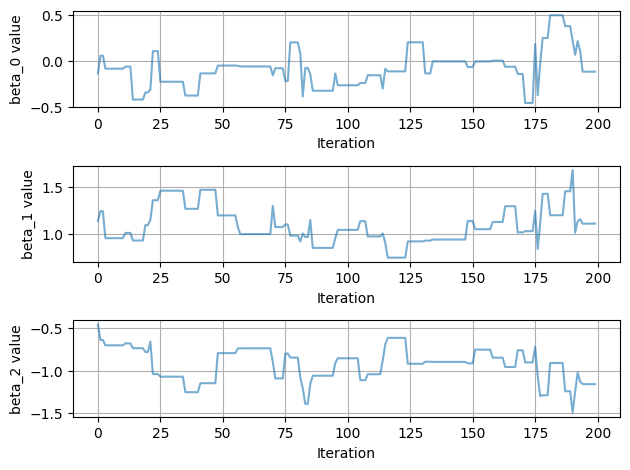

In [331]:
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(samples[0:200, i], alpha=0.6)
    plt.xlabel("Iteration")
    plt.ylabel(f"{parameter_names[i]} value")
    plt.grid(True)
plt.tight_layout()
plt.show()

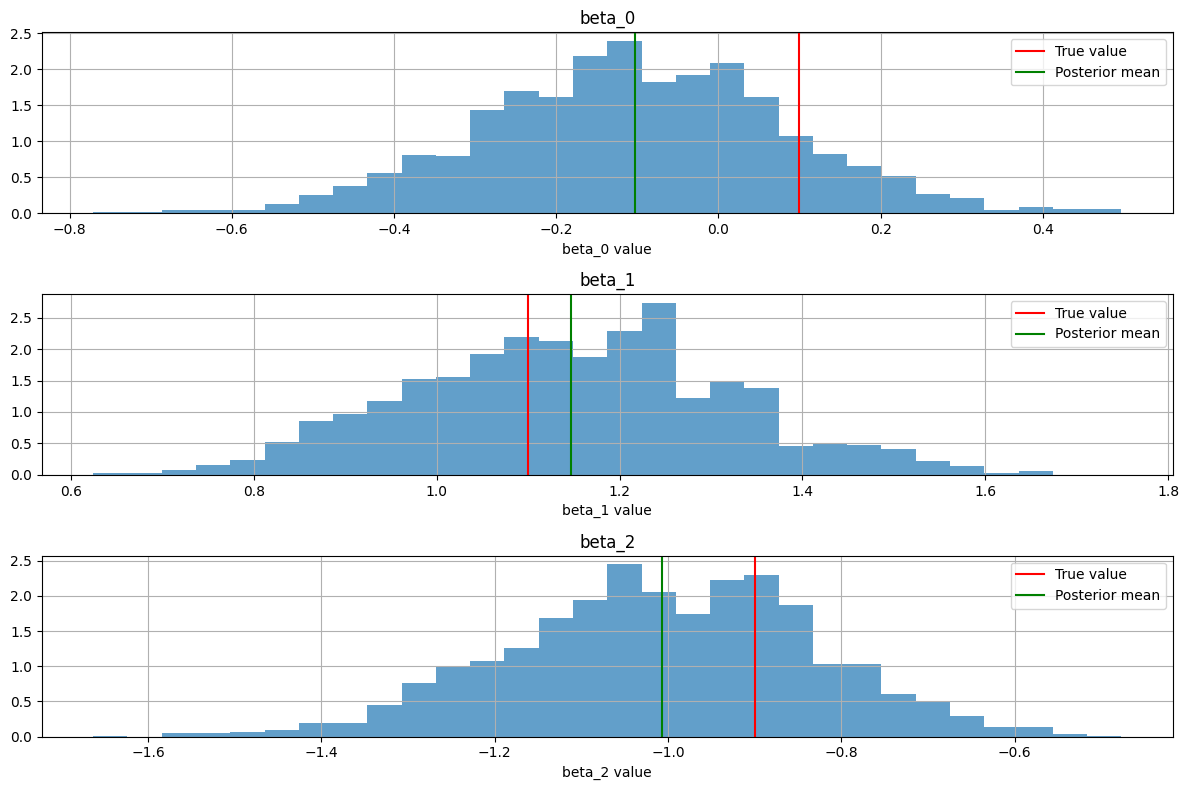

Posterior Standard Deviation of beta_0: 0.18633773538512924
Posterior Mean of beta_0: -0.10236361371239001
True Value of beta_0: 0.1
Posterior Standard Deviation of beta_1: 0.17401096459378834
Posterior Mean of beta_1: 1.1473760890683615
True Value of beta_1: 1.1
Posterior Standard Deviation of beta_2: 0.1750935945602721
Posterior Mean of beta_2: -1.0072186345254206
True Value of beta_2: -0.9


In [346]:
burn_in = 150
burned_samples = samples[burn_in:]

posterior_means = np.mean(burned_samples, axis=0)
posterior_stds = np.std(burned_samples, axis=0)

plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.hist(burned_samples[:, i], bins=30, density=True, alpha=0.7)
    plt.axvline(true_value := beta[i], color='r', label="True value")
    plt.axvline(posterior_means[i], color='g', label="Posterior mean")
    plt.title(parameter_names[i])
    plt.xlabel(f"{parameter_names[i]} value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

for i in range(3):
    print(f"Posterior Standard Deviation of {parameter_names[i]}: {posterior_stds[i]}")
    print(f"Posterior Mean of {parameter_names[i]}: {posterior_means[i]}")
    print(f"True Value of {parameter_names[i]}: {beta[i]}")

## Gelman Rubin Statistic

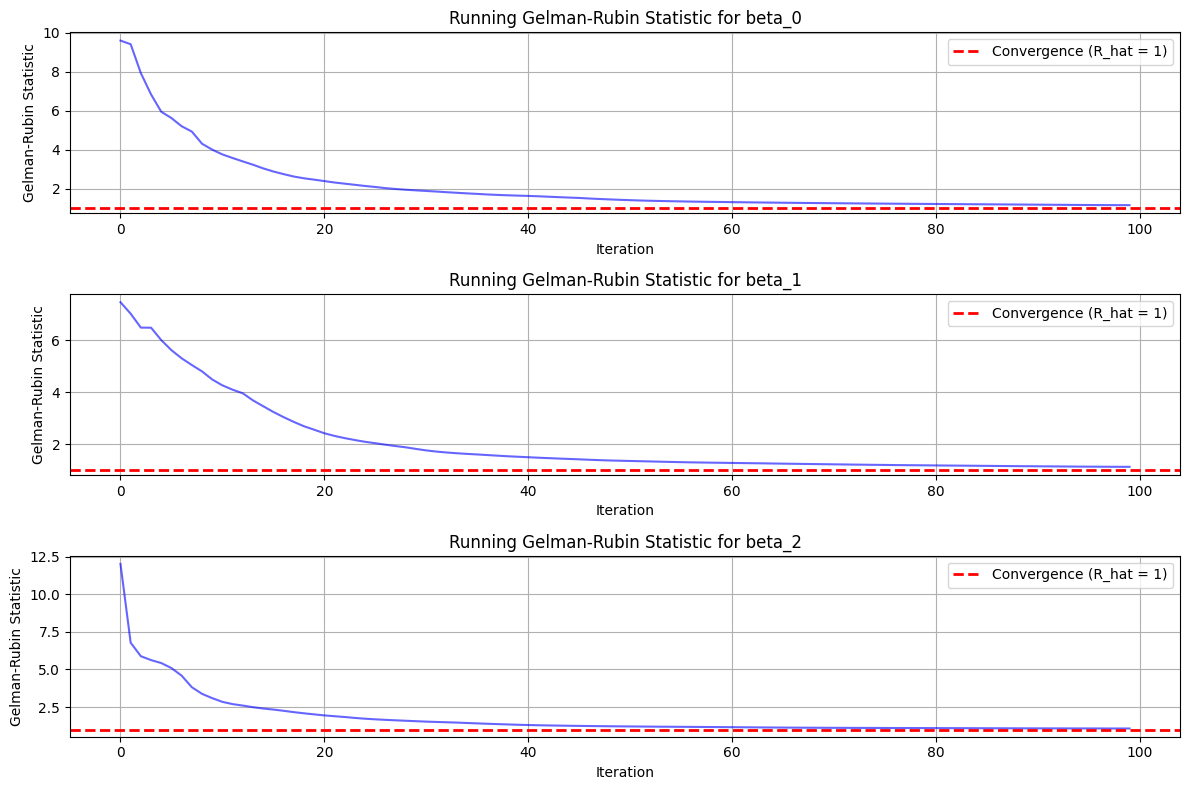

In [347]:
def gelman_rubin(chains):
    _, N, _ = chains.shape
    chain_means = np.mean(chains, axis=1)
    W = np.var(chains, axis=1, ddof=1).mean(axis=0)
    chain_mean = np.mean(chain_means, axis=0)
    B = np.var(chain_means, axis=0) * N
    R_hat = np.sqrt((1 - 1/N) + (B / (N * W)))
    return R_hat

num_chains = 20
num_samples = 100
chains = []

for _ in range(num_chains):
    chain_samples,_ = metropolis_hastings(X, Y, num_samples=num_samples, proposalsd=bestsd, priorsd=1.5)
    chains.append(chain_samples)


chains = np.array(chains)

R_hat_values = np.array([gelman_rubin(chains[:, :i+1]) for i in range(1, chains.shape[1] + 1)])

parameter_names = ['beta_0', 'beta_1', 'beta_2']
plt.figure(figsize=(12, 8))
for i in range(3):
    plt.subplot(3, 1, i+1)
    plt.plot(R_hat_values[:, i], color='blue', alpha=0.6)
    plt.axhline(1, color='r', linestyle='dashed', linewidth=2, label="Convergence (R_hat = 1)")
    plt.title(f"Running Gelman-Rubin Statistic for {parameter_names[i]}")
    plt.xlabel("Iteration")
    plt.ylabel("Gelman-Rubin Statistic")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()



# 3

In [301]:
betashigh = np.concatenate([[0.1,1.1,-0.9], np.random.uniform(-2, 2, 6)])
print(betashigh)
Xhigh,Yhigh=generate_logistic(betashigh,200)
np.bincount(Yhigh)

[ 0.1         1.1        -0.9         1.6515511   0.61325964  1.8750013
 -0.29641474 -0.04009536 -0.20259245]


array([ 91, 109], dtype=int64)

In [337]:
samples_high,acceptance_rate_high=metropolis_hastings(Xhigh, Yhigh, num_samples=10000, proposalsd=0.18, priorsd=1.5)
print(acceptance_rate_high)

0.2069


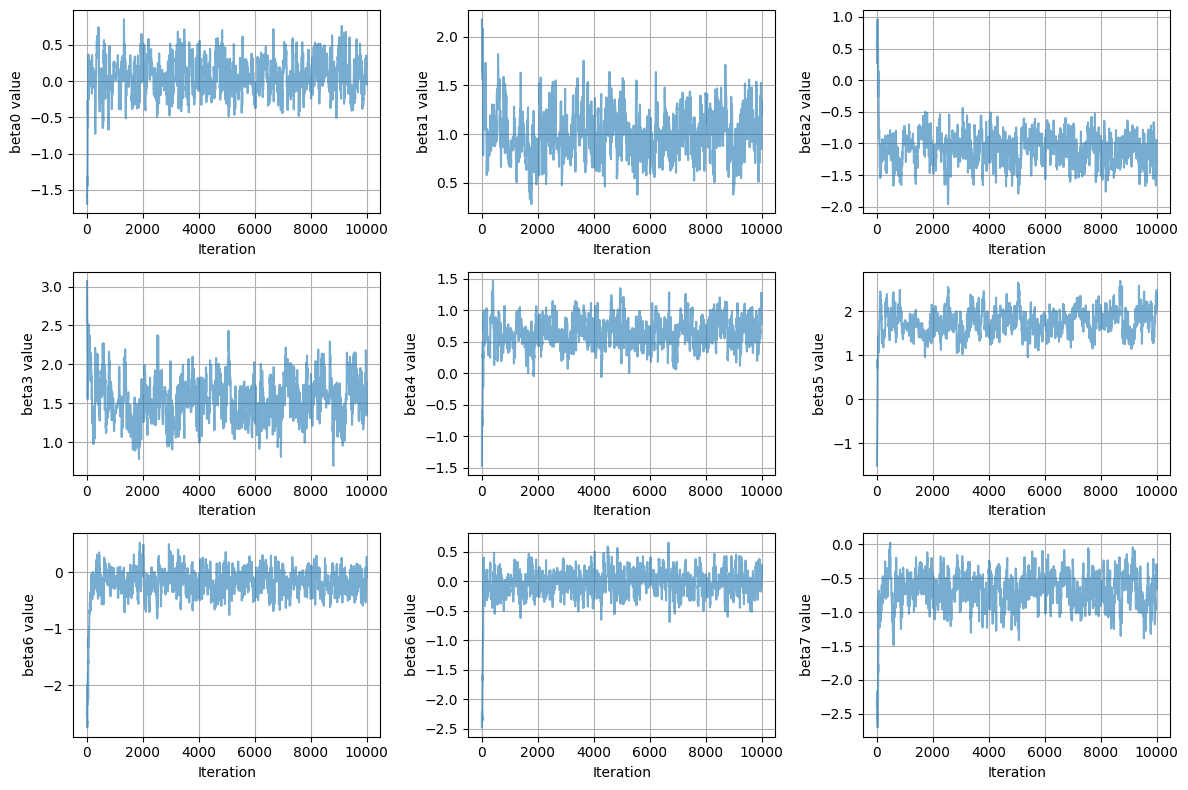

In [ ]:
parameter_names_high = ['beta0', 'beta1', 'beta2','beta3','beta4','beta5','beta6','beta6','beta7','beta8']
plt.figure(figsize=(12, 8))

for i in range(9):
    plt.subplot(3,3, i+1)
    plt.plot(samples_high[:, i], alpha=0.6)
    plt.xlabel("Iteration")
    plt.ylabel(f"{parameter_names_high[i]} value")
    plt.grid(True)

plt.tight_layout()
plt.show()

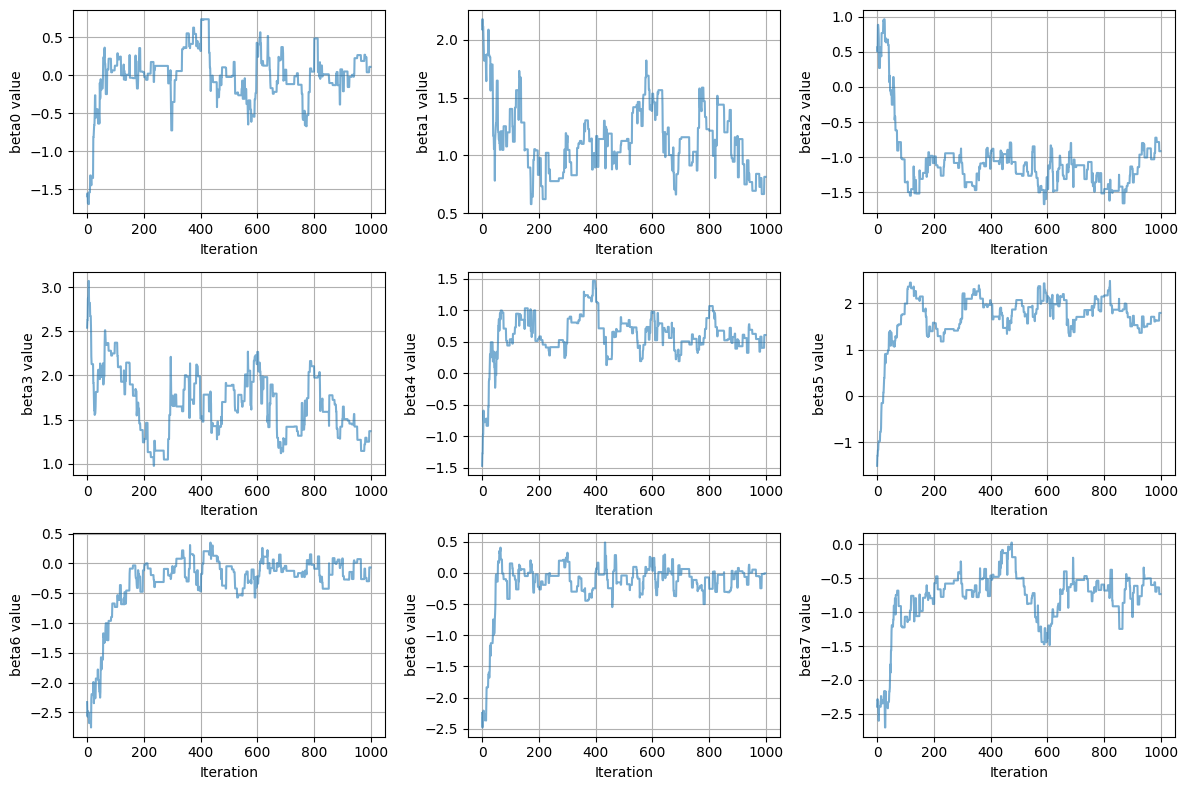

In [304]:
plt.figure(figsize=(12, 8))

for i in range(9):
    plt.subplot(3,3, i+1)
    plt.plot(samples_high[0:1000, i], alpha=0.6)
    plt.xlabel("Iteration")
    plt.ylabel(f"{parameter_names_high[i]} value")
    plt.grid(True)

plt.tight_layout()
plt.show()

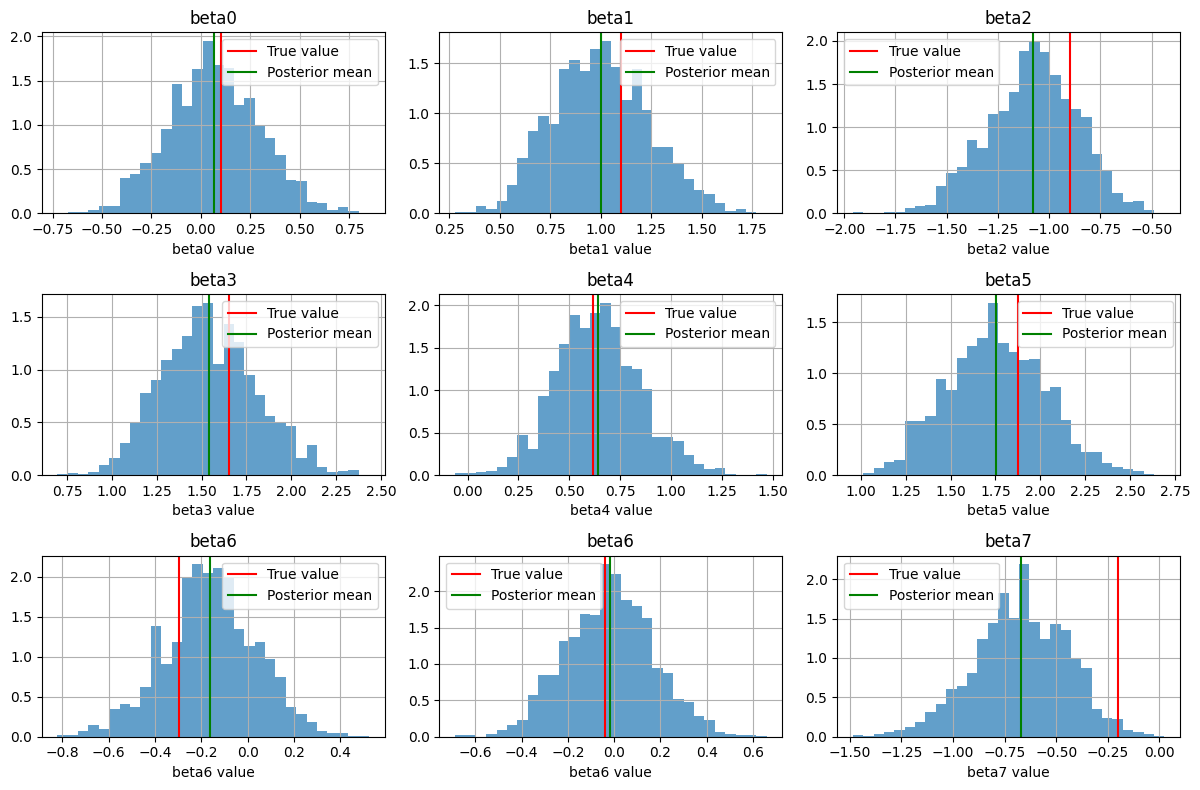

Posterior Standard Deviation of beta0: 0.23252924563641092
Posterior Mean of beta0: 0.06793992594952426
True Value of beta0: 0.1
Posterior Standard Deviation of beta1: 0.23734661807363744
Posterior Mean of beta1: 1.0001564542111574
True Value of beta1: 1.1
Posterior Standard Deviation of beta2: 0.2190247388327991
Posterior Mean of beta2: -1.080298332466364
True Value of beta2: -0.9
Posterior Standard Deviation of beta3: 0.265549727037236
Posterior Mean of beta3: 1.5408724889751324
True Value of beta3: 1.6515511038262103
Posterior Standard Deviation of beta4: 0.2085272807762636
Posterior Mean of beta4: 0.6403094152714556
True Value of beta4: 0.6132596418405072
Posterior Standard Deviation of beta5: 0.2743769952743889
Posterior Mean of beta5: 1.7528109703572614
True Value of beta5: 1.8750012984631956
Posterior Standard Deviation of beta6: 0.1991916026540177
Posterior Mean of beta6: -0.16384348492238618
True Value of beta6: -0.2964147448659924
Posterior Standard Deviation of beta6: 0.1905

In [305]:
burn_in_high = 200
burned_samples_high = samples_high[burn_in:]

posterior_means_high = np.mean(burned_samples_high, axis=0)
posterior_stds_high = np.std(burned_samples_high, axis=0)

plt.figure(figsize=(12, 8))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.hist(burned_samples_high[:, i], bins=30, density=True, alpha=0.7)
    plt.axvline(true_value := betashigh[i], color='r', label="True value")
    plt.axvline(posterior_means_high[i], color='g', label="Posterior mean")
    plt.title(parameter_names_high[i])
    plt.xlabel(f"{parameter_names_high[i]} value")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

for i in range(9):
    print(f"Posterior Standard Deviation of {parameter_names_high[i]}: {posterior_stds_high[i]}")
    print(f"Posterior Mean of {parameter_names_high[i]}: {posterior_means_high[i]}")
    print(f"True Value of {parameter_names_high[i]}: {betashigh[i]}")

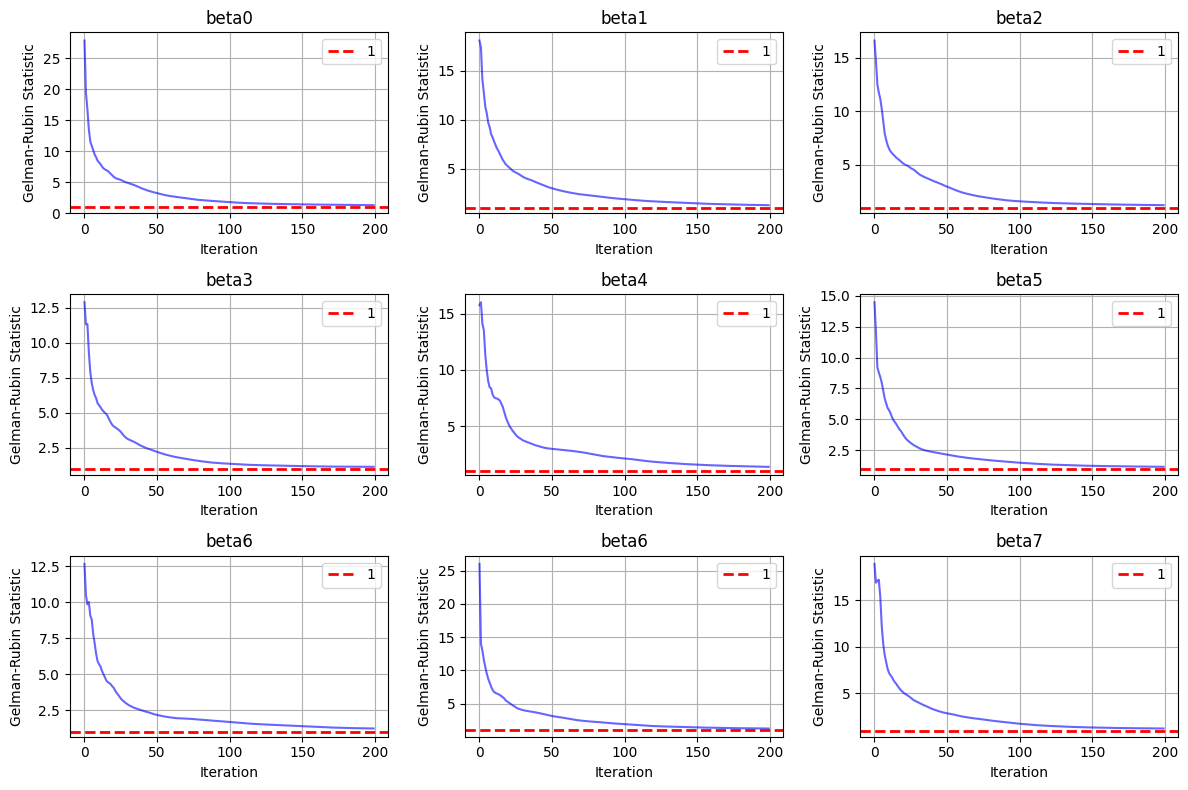

In [306]:
num_chains = 20
num_samples = 200
chainshigh = []

for _ in range(num_chains):
    chain_samples_high,_ = metropolis_hastings(Xhigh, Yhigh, num_samples=num_samples, proposalsd=0.18, priorsd=1.5)
    chainshigh.append(chain_samples_high)

chainshigh = np.array(chainshigh)
R_hat_values_high= np.array([gelman_rubin(chainshigh[:, :i+1]) for i in range(1, chainshigh.shape[1] + 1)])


plt.figure(figsize=(12, 8))
for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(R_hat_values_high[:, i], color='blue', alpha=0.6)
    plt.axhline(1, color='r', linestyle='dashed', linewidth=2, label="1")
    plt.title(parameter_names_high[i])
    plt.xlabel("Iteration")
    plt.ylabel("Gelman-Rubin Statistic")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()



# 4

In [351]:
def metropolis_hastings_conditional(X, y, beta, index, proposalsd, priorsd, acceptance_count):
    currentbeta = beta.copy()
    beta_proposed = currentbeta.copy()
    beta_proposed[index] = np.random.normal(currentbeta[index], proposalsd)  # update only the specified beta
    
    currentlog = log_posterior(X, y, currentbeta, priorsd)
    proposedlog = log_posterior(X, y, beta_proposed, priorsd)
    
    alpha = min(1, np.exp(proposedlog - currentlog))
    
    if np.random.rand() < alpha:
        acceptance_count[index] += 1  
        return beta_proposed
    else:
        return currentbeta  

def metropolis_within_gibbs(X, y, num_samples=100, proposalsd=0.2, priorsd=1.5):
    num_parameters = 9  
    currentbeta = np.random.normal(0, 1, num_parameters)  
    acceptance_count = np.zeros(num_parameters)

    samples = []

    for _ in range(num_samples):
        for i in range(num_parameters): 
            currentbeta = metropolis_hastings_conditional(X, y, currentbeta, i, proposalsd, priorsd, acceptance_count)
        samples.append(currentbeta)
    
    acceptance_rate = acceptance_count / num_samples
    
    return np.array(samples), acceptance_rate


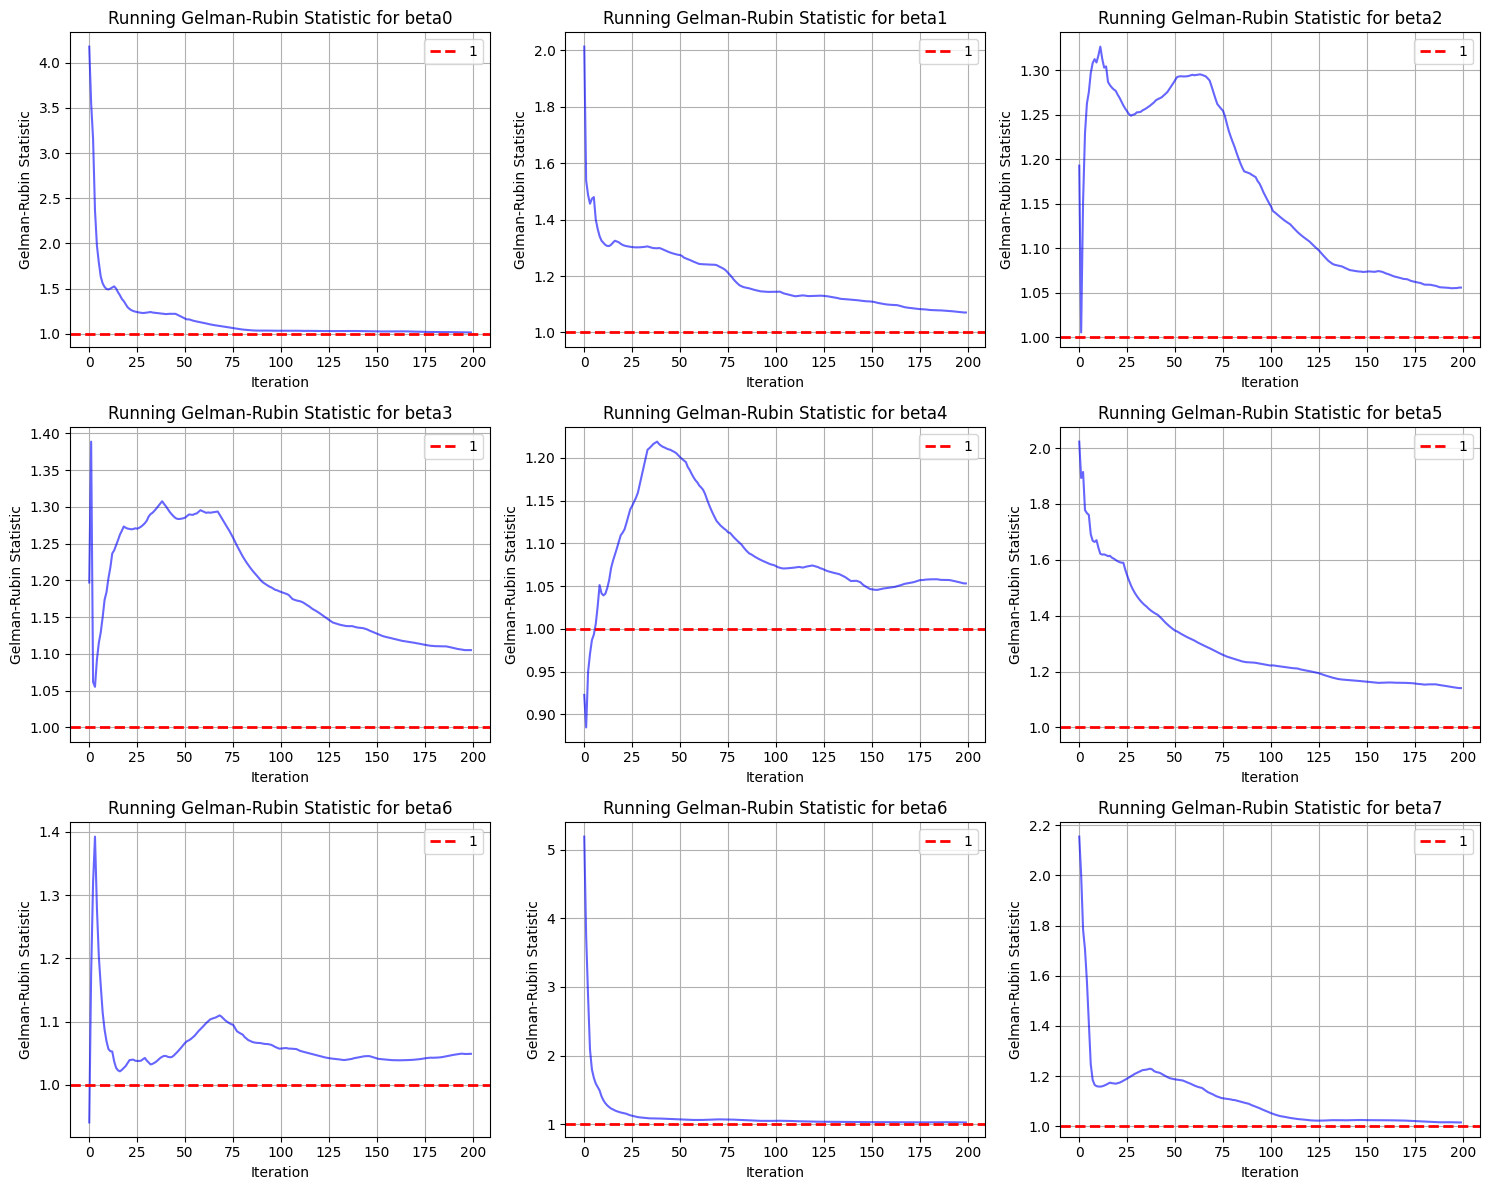

Acceptance rates for each conditional
[[0.155 0.135 0.12  0.105 0.095 0.14  0.125 0.16  0.155]
 [0.17  0.125 0.14  0.1   0.135 0.11  0.185 0.115 0.14 ]
 [0.16  0.115 0.105 0.1   0.12  0.185 0.12  0.14  0.125]
 [0.135 0.125 0.11  0.09  0.1   0.165 0.115 0.1   0.185]
 [0.175 0.115 0.175 0.145 0.14  0.185 0.145 0.115 0.13 ]
 [0.175 0.125 0.135 0.165 0.18  0.14  0.13  0.13  0.16 ]
 [0.11  0.11  0.155 0.1   0.1   0.11  0.1   0.15  0.1  ]
 [0.125 0.12  0.095 0.13  0.13  0.115 0.13  0.11  0.065]
 [0.11  0.11  0.165 0.16  0.085 0.16  0.145 0.13  0.175]
 [0.13  0.105 0.105 0.14  0.085 0.12  0.11  0.13  0.105]]


In [ ]:
num_chains = 10
num_samples = 200
chainsmwg = []
acceptance_rates_mwg = np.zeros((num_chains, 9))  


for _ in range(num_chains):
    chain_samplesmwg, acceptance_rate = metropolis_within_gibbs(Xhigh, Yhigh, num_samples=num_samples, proposalsd=2, priorsd=1.5)
    chainsmwg.append(chain_samplesmwg)
    acceptance_rates_mwg[_, :] = acceptance_rate 

chainsmwg = np.array(chainsmwg)

Rmwg = np.array([gelman_rubin(chainsmwg[:, :i+1]) for i in range(1, chainsmwg.shape[1] + 1)])

plt.figure(figsize=(15, 12))
for i in range(9):
    plt.subplot(3, 3, i+1)  
    plt.plot(Rmwg[:, i], color='blue', alpha=0.6)
    plt.axhline(1, color='r', linestyle='dashed', linewidth=2, label="1")
    plt.title(f"Running Gelman-Rubin Statistic for {parameter_names_high[i]}")
    plt.xlabel("Iteration")
    plt.ylabel("Gelman-Rubin Statistic")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()

print("Acceptance rates for each conditional")
print(acceptance_rates_mwg)


# 5

In [ ]:
metropolis_hastings(Xhigh,Yhigh,1000,0.35,1.5)
metropolis_hastings(Xhigh,Yhigh,1000,0.15,1.5)

(array([[ 2.21291638,  1.27878908, -0.71086275, ...,  3.50688359,
         -1.55945277, -1.07551221],
        [ 2.41716746,  1.51146363, -0.56573997, ...,  3.23734778,
         -1.86789539, -0.96679269],
        [ 2.41716746,  1.51146363, -0.56573997, ...,  3.23734778,
         -1.86789539, -0.96679269],
        ...,
        [ 0.16041357,  1.62879243, -1.36665919, ..., -1.75031313,
          0.19074616, -0.26481153],
        [ 0.16041357,  1.62879243, -1.36665919, ..., -1.75031313,
          0.19074616, -0.26481153],
        [ 0.16041357,  1.62879243, -1.36665919, ..., -1.75031313,
          0.19074616, -0.26481153]]),
 0.391)

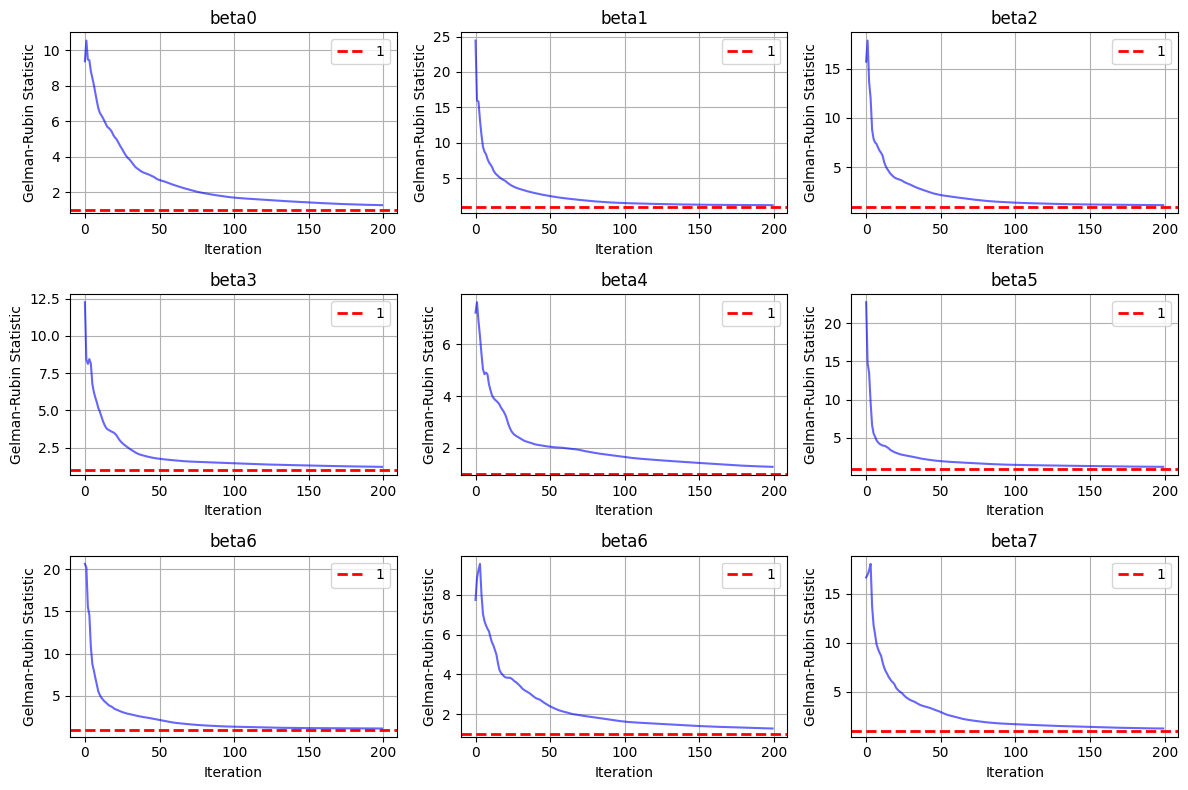

In [ ]:
def metropolis_hastingsrnd(X, y, num_samples=100, sdoptions=[0.35,0.15], priorsd=1.5):

    proposalsd=np.random.choice(sdoptions)
    dim = X.shape[1]
    currentbeta = np.random.multivariate_normal(np.zeros(dim+1), priorsd**2 * np.identity(dim+1))

    samples = []
    acceptance = 0

    for _ in range(num_samples):
        beta_proposed = np.random.multivariate_normal(currentbeta, proposalsd**2 * np.identity(dim+1))
        currentlog = log_posterior(X, y, currentbeta, priorsd)
        proposedlog = log_posterior(X, y, beta_proposed, priorsd)
        alpha = min(1, np.exp(proposedlog - currentlog))

        if np.random.rand() < alpha:
            currentbeta = beta_proposed
            acceptance += 1
            
        samples.append(currentbeta)
    samples=np.array(samples)
    return samples, acceptance / num_samples
    
chainshighrnd=[]

for _ in range(20):
    chain_samples_highrnd,_ = metropolis_hastingsrnd(Xhigh, Yhigh, 200, priorsd=1.5)
    chainshighrnd.append(chain_samples_highrnd)

chainshighrnd = np.array(chainshighrnd)

R_hat_values_highrnd= np.array([gelman_rubin(chainshighrnd[:, :i+1]) for i in range(1, chainshighrnd.shape[1] + 1)])


plt.figure(figsize=(12, 8))

for i in range(9):
    plt.subplot(3, 3, i+1)
    plt.plot(R_hat_values_highrnd[:, i], color='blue', alpha=0.6)
    plt.axhline(1, color='r', linestyle='dashed', linewidth=2, label="1")
    plt.title(parameter_names_high[i])
    plt.xlabel("Iteration")
    plt.ylabel("Gelman-Rubin Statistic")
    plt.legend()
    plt.grid(True)

plt.tight_layout()
plt.show()
        